# LGD Model

* LGD (loss given default): the percentrage of the exposure that was lost after the borrower defaulted

* LGD = 1 - recovery rate

In [12]:
#import libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#load_data
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv', index_col = 0)

It's a good practice to build models with data from borrowers that have had enough time to repay part of teh remaining debt. In our data, these are only the accounts that were written-off (*i.e.* their status should be **Charged Off**) 

In [3]:
loan_data_defaults = loan_data_inputs_train[loan_data_inputs_train['loan_status'].isin(['Charged Off',
                                                                                       'Does not meet the credit policy. Status:Charged Off'])]

## 1. Data Preprocessing


In [20]:
# deal with missing values
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace = True)
loan_data_defaults['pub_rec'].fillna(0,inplace = True)

### 1.1  Dependent Variables
We assumed that for defaulted borrwoers, **'funded_amnt'** refelects the total amount that was lost the moment the borrower defaulted

* recovery_rate = recoveries/funded_amnt

In [21]:
#Dependent Variable for LGD
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries']/loan_data_defaults['funded_amnt']

# set the boundaries for recovery_rate to be between 0 and 1
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate']>=1,1,loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate']<0,0,loan_data_defaults['recovery_rate'])

loan_data_defaults['recovery_rate'].describe()

count    34619.000000
mean         0.060900
std          0.089666
min          0.000000
25%          0.000000
50%          0.029497
75%          0.114313
max          1.000000
Name: recovery_rate, dtype: float64

(array([1.6847e+04, 1.4730e+03, 3.0850e+03, 1.1100e+03, 1.7160e+03,
        2.6120e+03, 3.8310e+03, 1.3930e+03, 9.7000e+02, 3.2700e+02,
        2.7300e+02, 2.0800e+02, 9.6000e+01, 7.6000e+01, 6.5000e+01,
        6.2000e+01, 4.3000e+01, 5.8000e+01, 4.2000e+01, 2.4000e+01,
        3.7000e+01, 2.4000e+01, 1.4000e+01, 1.5000e+01, 1.6000e+01,
        1.7000e+01, 1.5000e+01, 4.0000e+00, 1.0000e+01, 5.0000e+00,
        5.0000e+00, 6.0000e+00, 6.0000e+00, 7.0000e+00, 7.0000e+00,
        8.0000e+00, 5.0000e+00, 9.0000e+00, 7.0000e+00, 8.0000e+00,
        3.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00, 7.0000e+00,
        7.0000e+00, 1.3000e+01, 8.0000e+00, 8.0000e+00, 2.8000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

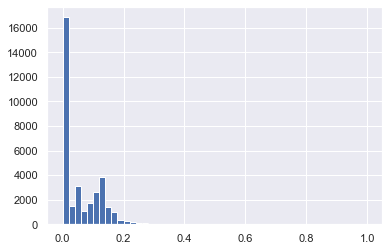

In [22]:
#visualise the data
plt.hist(loan_data_defaults['recovery_rate'],50)

We decided to use a two stage approach for LGD

In [23]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0,0,1)

## 1.2 Independent Variables

* For **dsicrete variables**, we create as many dummy variables as the number of categories (already done when work with PD model)
* For **contineous variables**, we can use them as they are or transform them. There is no need for fine classing or coarse classing

# 2. LGD Model

Here we use a two stage approach:
* 1. is the recovery rate equal to 0 or greater than 0? 
    - **Logistic Regression** if recovery rate = 0
    - **Linear Regression** to estimate recovery rate if recovery rate =! 0
* 2. If recovery rate is greater than 0, how much eaxctly is it?
    - Multiple Linear Regression

#### Train-test Split

In [24]:
lgd_inputs_stage_1_train,lgd_inputs_stage_1_test,lgd_targets_stage_1_train,lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1'],axis=1),
                                                                                                                      loan_data_defaults['recovery_rate_0_1'],test_size = 0.2,random_state = 42)

#### Preparing the inputs

In [25]:
#a list of features in consideration
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [26]:
# list of reference categories
features_reference_cat = ['grade:G', 'home_ownership:RENT', 'verification_status:Verified','purpose:credit_card','initial_list_status:f']

###  LGD Stage 1: Logistic Regression

In [27]:
#drop reference categories from training data
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all].drop(features_reference_cat,axis = 1)

In [28]:
#Build logistic regression model based on training data
reg_lgd_st_1 = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 1000)
reg_lgd_st_1.fit(lgd_inputs_stage_1_train,lgd_targets_stage_1_train)

LogisticRegression(max_iter=1000)

In [29]:
#create summary table
feature_name = lgd_inputs_stage_1_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'],data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept',reg_lgd_st_1.intercept_]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-3.770906e-04
1,grade:A,-6.945943e-05
2,grade:B,-2.309679e-04
3,grade:C,-3.311314e-04
4,grade:D,-5.780993e-05
5,grade:E,8.513562e-05
6,grade:F,1.990103e-04
7,home_ownership:MORTGAGE,-1.702751e-04
8,home_ownership:NONE,1.172823e-06
9,home_ownership:OTHER,8.056388e-08


Coefficients for continuous variabls reflect the change in log-odds that results from a unit change in the property the continuous variable measures

### Test Logistic Regression Model
Use test set to check model accuracy. We calculate ROC and AUROC

In [30]:
#pre-processing
#test dataset: drop reference categories from features
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat,axis = 1)

In [35]:
#use reg_lgd_st_1 to predict y_hat_test and y_hat_test_proba
y_hat_test_lgd_stage_1 = reg_lgd_st_1.predict(lgd_inputs_stage_1_test)
y_hat_test_proba_lgd_stage_1  = reg_lgd_st_1.predict_proba(lgd_inputs_stage_1_test)
#take only the probabilities
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:][:,1]
y_hat_test_proba_lgd_stage_1

array([0.66280069, 0.47812771, 0.60622538, ..., 0.60045145, 0.55998137,
       0.36819779])

In [36]:
#list predicted results and test_proba
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)],axis =1)
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
14352,1,0.662801
447209,0,0.478128
127834,1,0.606225
16455,1,0.763405
170733,1,0.509874


In [37]:
#Estimate accuracy with tr = 0.5
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1']> tr,1,0)
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'],
            df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
            rownames = ['Actual'],colnames = ['Predicted'])/df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.175910,0.271953
1,0.111496,0.440641


we see an accurancy at 0.6 according to the confusion matrix above

Text(0.5, 1.0, 'ROC curve')

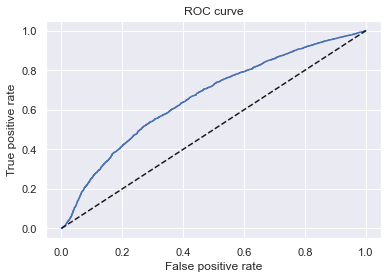

In [38]:
# ROC Curve and AuROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr,tpr,thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'],df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [39]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'],df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6622000463428341

Since we use logistic regression as a first stage to model LGD, it's important to have a large proportion of correctly classified values that are greater than 0, than to have correctly classified 0s

This is becuase during the 2nd stage model some values here classified as > 0 may still be estimated to be =0, hence correst the current misclassifictaion

In [ ]:
#save the model
import pickle
picke.dump(reg_lgd_st_1,open('lgd_model_stage_1.sav','wb'))

## Stage2 - linear regression

In [40]:
# chose a sub-group from  loan_data_defaults where 'recovery_rate_0_1' tis 1
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1']==1]

In [45]:
# train test split
lgd_inputs_stage2_train,lgd_inputs_stage_2_test,lgd_targets_stage_2_train,lgd_targets_stage2_test = train_test_split(lgd_stage_2_data.drop(['recovery_rate','recovery_rate_0_1'],axis=1),
                                                                    lgd_stage_2_data['recovery_rate'],test_size = 0.2,random_state = 42)

In [46]:
# prepare traing data
lgd_inputs_stage_2_train = lgd_inputs_stage2_train[features_all].drop(features_reference_cat,axis =1)

In [47]:
# train the linear regression model
reg_lgd_st_2 = linear_model.LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train,lgd_targets_stage_2_train)

LinearRegression()

In [48]:
# create a summary table showing feature name and corresponding coeficients
feature_name = lgd_inputs_stage_2_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'],data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept',reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,2.447859e-01
1,grade:A,-7.093375e-02
2,grade:B,-5.271342e-02
3,grade:C,-3.873294e-02
4,grade:D,-3.064719e-02
5,grade:E,-1.512458e-02
6,grade:F,-2.084199e-03
7,home_ownership:MORTGAGE,2.399904e-03
8,home_ownership:NONE,2.145625e-01
9,home_ownership:OTHER,5.044740e-03


A coefficient shows the change in the dependent variable that is going to occur as a result of a unit change in the respective independent variable

### linear regression evaluation

In [49]:
#preprare test dataset
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all].drop(features_reference_cat, axis =1)

In [50]:
#use reg_lgd_st_2 to predict dependent variable
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [54]:
#calculate correlation between two series

#reset index for lgd_targets_stage2_test so it has the same index as y_hat_test_lgd_stage_2
lgd_targets_stage_2_test_temp = lgd_targets_stage2_test.reset_index(drop = True)
#apply the correlation methods
pd.concat([lgd_targets_stage_2_test_temp,pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.296761
0,0.296761,1.000000


correlation at 0.3 is satisfactory for a LGD model.

We can also look at the distribution between actual and predicted values

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recovery_rate', ylabel='Density'>

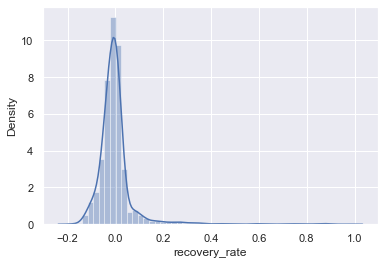

In [116]:
sns.distplot(lgd_targets_stage2_test - y_hat_test_lgd_stage_2)

It re-sembles a normal distribution and most residuals are normally distributed around zero

In [ ]:
pickle.dump(reg_lgd_st_2,open('lgd_model_stage_2.sav'),'wb')

## Combining stage 1&2

In [55]:
#use reg_lgd_st_2 to predict inputs data from stage 1
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [56]:
#calculate total rocovery rate
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [57]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,6924.000000
mean,0.074681
std,0.052869
min,0.000000
25%,0.000000
50%,0.091493
75%,0.116910
max,0.307224


In [58]:
# Cap y_hat_test_lgd to be between [0,1]
y_hat_test_lgd = np.where(y_hat_test_lgd<0,0,y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd>0,1,y_hat_test_lgd)

In [59]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,6924.000000
mean,0.712594
std,0.452585
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000
